<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter10/calibration_to_account_for_sampling_or_weighting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip3 install xgboost==1.6.1 imbalanced-learn==0.9.1 seaborn==0.12.1

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

## Synthetic data set prep:

In [3]:
def make_data(sep):
    X, y = make_classification(
        n_samples=5000,
        n_features=2,
        n_redundant=0,
        n_clusters_per_class=1,
        weights=[0.995],
        class_sep=sep,  # how separate the classes are
        random_state=1,
    )

    # trasform arrays into pandas df and series
    X = pd.DataFrame(X, columns=["feature_1", "feature_2"])
    y = pd.Series(y)

    return X, y

0    4950
1      50
dtype: int64


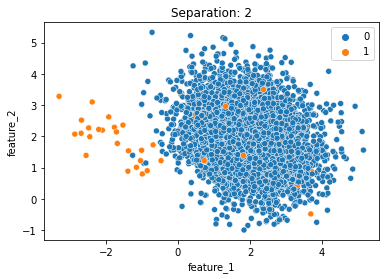

0    4950
1      50
dtype: int64


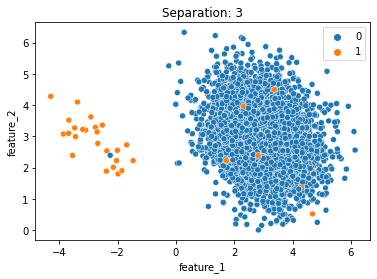

In [4]:
# make datasets with different class separateness
# and plot
synthetic_datasets = []
for sep in [2, 3]:
    X, y = make_data(sep)
    synthetic_datasets.append(
        {
            "data": np.array(X),
            "target": np.array(y),
            "DESCR": "synthetic data, sep: " + str(sep),
        }
    )
    print(y.value_counts())
    sns.scatterplot(data=X, x="feature_1", y="feature_2", hue=y)
    plt.title("Separation: {}".format(sep))
    plt.show()

## Real world data set

In [5]:
# Abalone dataset, and thyroid dataset
from imblearn.datasets import fetch_datasets

# these datasets are baked into imbalanced-learn
dataset_list = ["thyroid_sick", "abalone_19"]

In [6]:
# print class imbalance of each dataset
from collections import Counter
from sklearn.preprocessing import LabelEncoder

all_datasets = []
all_datasets = synthetic_datasets
le = LabelEncoder()
for dataset in dataset_list:
    data = fetch_datasets()[dataset]
    data["target"] = le.fit_transform(data["target"])
    all_datasets.append(data)

for item in all_datasets:
    print(Counter(item["target"]))

Counter({0: 4950, 1: 50})
Counter({0: 4950, 1: 50})
Counter({0: 3541, 1: 231})
Counter({0: 4145, 1: 32})


In [7]:
# function to train random forests and evaluate the performance
from numpy import mean
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    cross_val_predict,
)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


def fit_model(classifier, X_train, y_train, sampler=None):
    model = Pipeline(
        steps=[
            ("minMaxScaling", MinMaxScaler()),
            ("sampler", sampler),
            ("model", classifier),
        ]
    )
    model.fit(X_train, y_train)
    return model

# Impact of oversampling techniques on calibration of a model

### Models used: LogisticRegression and XGBoost

In [8]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

oversampler_map = {
    "RandomOverSampler": RandomOverSampler(sampling_strategy="auto", random_state=0),
}

In [9]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV


def plot_calibration_curve(run_details, axis, y_true, probs, bins, model):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, probs, n_bins=bins, strategy="quantile"
    )

    max_val = max(mean_predicted_value)

    model_name = "LogisticRegression calibration"
    axis.plot(mean_predicted_value, fraction_of_positives, label=model_name)
    axis.plot(
        np.linspace(0, max_val, bins),
        np.linspace(0, max_val, bins),
        linestyle="--",
        color="gray",
        label="Perfect calibration",
    )

    axis.set(xlabel="Probability Predictions")
    axis.set(ylabel="Fraction of positives")
    axis.set(title=run_details)
    axis.legend(loc="upper left")

In [10]:
def fit_model_call_plot_calibration_curve(
    sampler_name, sampler, data, model, X_train, X_test, y_train, y_test, axis
):
    run_details = sampler_name + " | Dataset description: " + data["DESCR"]

    model = fit_model(model, X_train, y_train, sampler)
    y_pred = model.predict_proba(X_test)[:, 1]
    plot_calibration_curve(run_details, axis, y_test, y_pred, bins=8, model=model)
    return y_pred, run_details

In [11]:
def calibrate_scores(y_pred, y_train):
    y_pred_odds = 1 / ((1 / y_pred) - 1)
    prop_class_1 = Counter(y_train)[1] / len(y_train)  # (count of 1s)/(len of dataset)
    y_adj_odds = y_pred_odds * (prop_class_1 / (1 - prop_class_1))
    y_adj_probs = 1 / (1 + 1 / y_adj_odds)
    return y_adj_probs

In [12]:
# now we train several models, with the different Sampling techniques
def draw_plots(sampler_map):
    for data in all_datasets:
        X_train, X_test, y_train, y_test = train_test_split(
            data["data"],
            data["target"],
            test_size=0.3,
            random_state=0,
        )

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 1))

        for sampler_name, sampler in sampler_map.items():
            lr = LogisticRegression(random_state=0, max_iter=2000)
            y_pred, run_details = fit_model_call_plot_calibration_curve(
                sampler_name,
                sampler,
                data,
                lr,
                X_train,
                X_test,
                y_train,
                y_test,
                axes[0],
            )

            # now calibrate scores
            y_adj_probs = calibrate_scores(y_pred, y_train)
            plot_calibration_curve(
                "calibrated scores | " + run_details,
                axes[1],
                y_test,
                y_adj_probs,
                bins=8,
                model=lr,
            )

        plt.show()

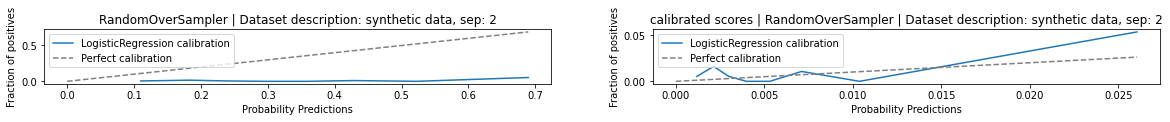

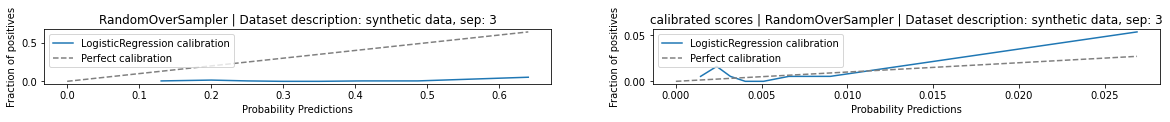

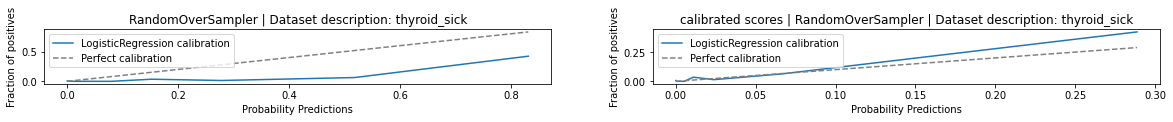

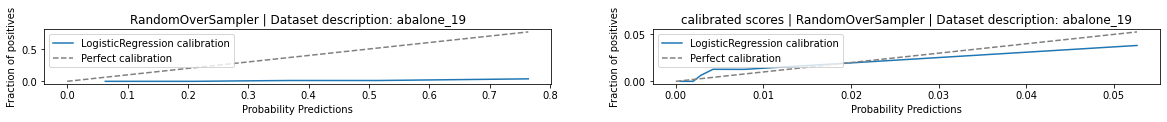

In [13]:
draw_plots(oversampler_map)

# Impact of undersampling techniques on calibration of a model

In [14]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

undersampler_map = {
    "RandomUnderSampler": RandomUnderSampler(
        sampling_strategy="auto", random_state=0, replacement=False
    )
}

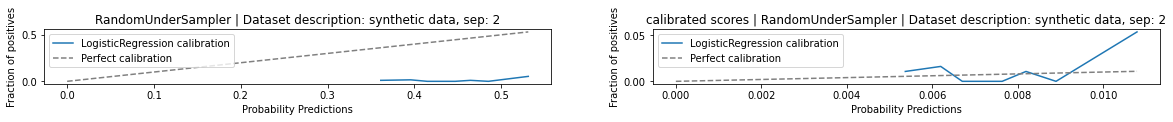

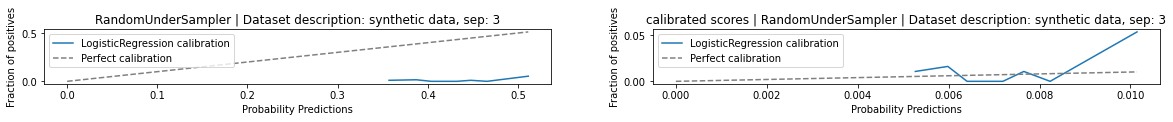

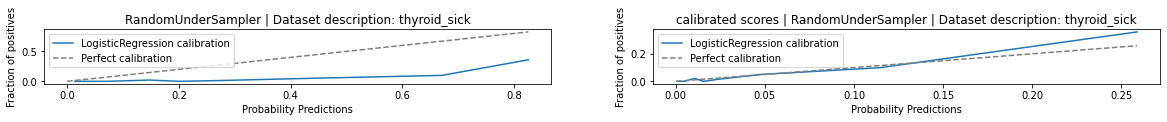

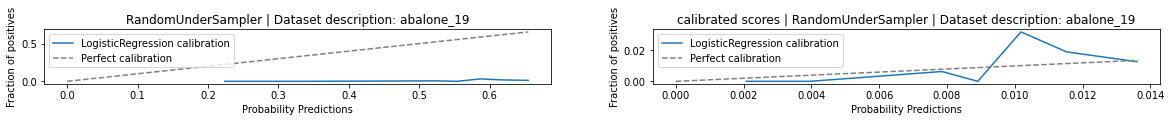

In [15]:
draw_plots(undersampler_map)

# Impact of cost-sensitive techniques on calibration of a model



In [16]:
def fit_model_call_plot_calibration_curve(
    data, model, X_train, X_test, y_train, y_test, axis
):
    run_details = "Dataset description: " + data["DESCR"]
    model = fit_model(model, X_train, y_train)
    model_probs = model.predict_proba(X_test)[:, 1]
    plot_calibration_curve(run_details, axis, y_test, model_probs, bins=8, model=model)
    return model_probs, run_details


def draw_plots():
    for data in all_datasets:
        X_train, X_test, y_train, y_test = train_test_split(
            data["data"],
            data["target"],
            test_size=0.3,
            random_state=0,
        )

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 1))

        lr = LogisticRegression(class_weight="balanced", random_state=0, max_iter=2000)
        y_pred, run_details = fit_model_call_plot_calibration_curve(
            data, lr, X_train, X_test, y_train, y_test, axes[0]
        )

        # now calibrate scores
        y_adj_probs = calibrate_scores(y_pred, y_train)
        plot_calibration_curve(
            "calibrated scores | " + run_details,
            axes[1],
            y_test,
            y_adj_probs,
            bins=8,
            model=lr,
        )

        plt.show()

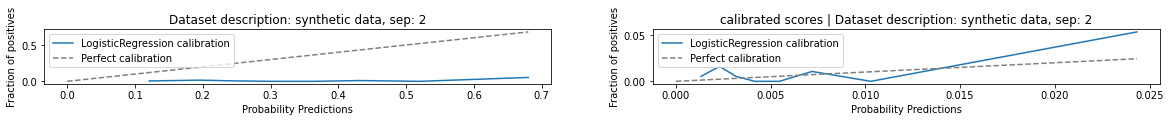

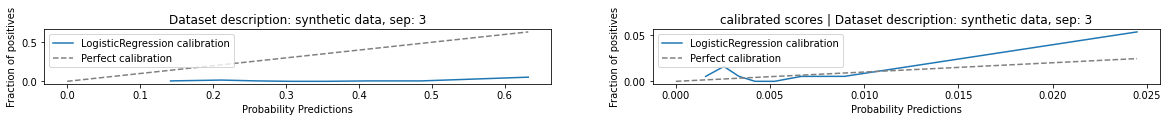

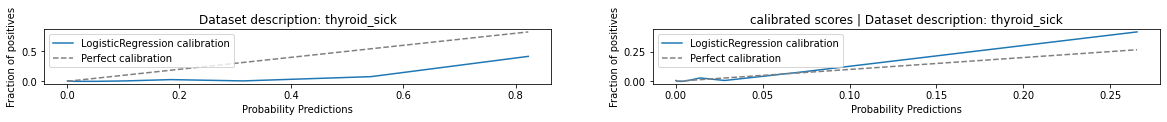

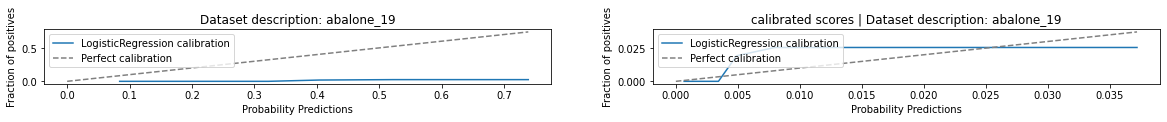

In [17]:
draw_plots()